Notes :
When you add age and gender, the shap value does not give proper output

# Read the input dataset :

1. usable_samples_ADNI.json : stores the IID for each row of PRS_feature_matrix.npy
2. PRS_feature_matrix.npy : PR Score for different features
3. Covar_FILE_bigger_dataset : for reading covar such as age, gender
4. Final_Samples.json : test data

In [1]:
if True:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

import pandas as pd
import numpy as np
import json
import random

import os
import time
import sys

import torch as t
from torch import nn
from torch.autograd import Variable
import torch
from torch.utils import data

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import shap
from copy import deepcopy

import pickle
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

Show the installed packages with their versions

In [2]:
!conda list

# packages in environment at C:\ProgramData\Anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
alabaster                 0.7.12                   py37_0  
anaconda                  2020.02                  py37_0  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.12                   py37_0  
anaconda-project          0.8.4                      py_0  
appdirs                   1.4.3                    pypi_0    pypi
argh                      0.26.2                   py37_0  
asn1crypto                1.3.0                    py37_0  
astroid                   2.3.3                    py37_0  
astropy                   4.0              py37he774522_0  
atomicwrites              1.3.0                    py37_1  
attrs                     19.3.0                     py_0  
autopep8                  1.4.4                      py_0  
babel                     2.8.

In [3]:
Final_Samples_path = 'Final_Samples_6yrs.json'
Final_Samples = json.load(open(Final_Samples_path, 'r')) 
usable_samples_ADNI = json.load(open('./usable_samples_ADNI.json'))
PRS_orig_feature_matrix = np.load('./PRS_feature_matrix.npy').astype(np.float32)
# normalize feature matrix
PRS_orig_feature_matrix = (PRS_orig_feature_matrix - PRS_orig_feature_matrix.mean(0))/PRS_orig_feature_matrix.std(0)
# PRS_orig_feature_matrix.shape[1], len(usable_samples_ADNI), usable_samples_ADNI
num_features=PRS_orig_feature_matrix.shape[1]
print(num_features)

39


In [4]:
covar_df = pd.read_csv('./COVAR_FILE_bigger_dataset.txt', ' ') 
print("shape",covar_df.shape)
print( covar_df[['AGE', 'PTGENDER']].shape, covar_df[['AGE', 'PTGENDER']].dropna().shape ) 
# PC - Principal Component

# trying to normalize AGE with having max age of 100
covar_df['AGE'] = covar_df['AGE'] / 100.0
print( covar_df.head() )

shape (1817, 14)
(1817, 2) (1817, 2)
                FID               IID       PC1       PC2       PC3       PC4  \
0  ADNI3_036_S_6231  ADNI3_036_S_6231 -0.006724 -0.010617  0.001596 -0.000460   
1  ADNI3_006_S_6277  ADNI3_006_S_6277 -0.010432 -0.010269  0.012757  0.006921   
2  ADNI3_129_S_6146  ADNI3_129_S_6146 -0.004919 -0.011656 -0.035521  0.064641   
3  ADNI3_033_S_6352  ADNI3_033_S_6352 -0.014069 -0.010279  0.020014  0.053023   
4  ADNI3_027_S_6183  ADNI3_027_S_6183 -0.010766 -0.012370 -0.010960  0.029830   

        PC5       PC6       PC7       PC8       PC9      PC10  PTGENDER    AGE  
0 -0.013131 -0.005855 -0.005142 -0.009063 -0.001739 -0.012863         1  0.691  
1 -0.014958 -0.005860 -0.027775 -0.009632  0.054966  0.087390         1  0.707  
2  0.012094  0.003860  0.035955  0.006561  0.019736 -0.023304         1  0.655  
3  0.023691  0.000247 -0.002273 -0.030627 -0.053461  0.049984         0  0.714  
4 -0.019520 -0.001955  0.023844  0.079138  0.002207  0.008892         0

# Alter parameters :
    1. Number of features
    2. Number of Hidden Layers 
    3. Dimension of Hidden Layers

In [5]:
num_features = 39
hidden = 4
hidden_dimension = 32

In [6]:
# take the first num_features column from PRS_feature_matrix
PRS_feature_matrix = PRS_orig_feature_matrix
PRS_feature_matrix = PRS_feature_matrix[:, :num_features]
print(PRS_feature_matrix.shape)

(1816, 39)


Final Samples has two columns of data :
    1. ID 
    2. output - true / false
    
Get the length of positive and negative samples of test dataset

In [7]:
# positive samples - output true
# negative samples - output false
len_positive_samples = 0
len_negative_samples = 0
for x in Final_Samples:
    if x[1] == 1 :
        len_positive_samples += 1
    else :
        len_negative_samples += 1
        
print(len(Final_Samples))
print(len_positive_samples)
print(len_negative_samples)

974
654
320


# Combining covar data with PRS Feature Matrix

In [8]:
# cnt = number of missing IDs for which covar data doesn't exist
cnt = 0
print("Before adding covar_df columns, shape : ",PRS_feature_matrix.shape)
# adding ( total columns - 2 ) of covar_df , excluding FID, IID
FEATURE_MATRIX = np.concatenate([PRS_feature_matrix, np.zeros([PRS_feature_matrix.shape[0], covar_df.shape[1] - 2 ])], 1).astype(np.float32)
print("Before adding covar_df columns, shape : ",FEATURE_MATRIX.shape)
for sample in usable_samples_ADNI:
    # taking from the PCs, skipping the first two columns of IID, FID
    covar = covar_df[covar_df['IID'] == sample].to_numpy()[:, 2:].astype(np.float32) 
    # shape[0] = 1 means a row is found in covar for the following sample ID
    # if not, that means no covar data exists for the sample in usable_samples_ADNI
    if covar.shape[0] != 1:
#         print(covar.shape)
#         print(sample)
        cnt += 1
        continue
    # Adding the covar values to the feature matrix
    FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar


print("Count of missing samples for covar data : ", cnt)
#     FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar # naeem's modification
# cnt/FEATURE_MATRIX.shape[0], FEATURE_MATRIX[:2], PRS_feature_matrix[:2]

Before adding covar_df columns, shape :  (1816, 39)
Before adding covar_df columns, shape :  (1816, 51)
Count of missing samples for covar data :  234


# Create directory for saving shap figures

In [9]:
path = "./shap/" + str(num_features)
if not os.path.exists(path):
    os.makedirs(path)

# Storing the index with the Age = 0

age is zero for the rows that the covar data was not found

In [10]:
age_zero = 0
age_zero_idx = []
for i in range( len(FEATURE_MATRIX) ):
    if FEATURE_MATRIX[i, -1] == 0.00:
        age_zero += 1
        age_zero_idx.append(i)
        
print(age_zero)

234


# Indices of features to consider

In [11]:


# feature_indices_to_consider = list(range(23))#list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# naeem modified
print(FEATURE_MATRIX.shape[1])
last_idx = FEATURE_MATRIX.shape[1] - 1
# feature_indices_to_consider = list(range(num_features))  + [last_idx - 1, last_idx] #list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# remove_indices = [1, 2, 3]
# for i in remove_indices:
#     feature_indices_to_consider.remove(i)

feature_indices_to_consider = list(range(23, 36))

# feature_indices_to_consider = [ 4, 11, 14, 21, 23, 26, 32, 34, 46]

# feature_indices_to_consider = [ 9, 10, 11, 14, 21, 23, 26, 28, 32, 34, 46]
# feature_indices_to_consider = [9, 10, 28, 34, 46]

print(feature_indices_to_consider)
# feature_indices_to_consider = [1, 2, 3, 11, 14, 21, 23, 26, 32, 45]
# feature_indices_to_consider = [2, 26, 32, 45]


51
[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


# Functions & Classes

In [12]:
# save_in_file: saves model accuracy in a text file
#     args : model_name : name of model with layers and dimensions
#            accuracy : accuracy  score
def save_in_file(model_name, accuracy):
    model_file = open("model_details.txt","a")
    model_file.write(model_name + " -> accuracy : " + str(accuracy) + "\n" )
    model_file.close() 

In [13]:
class simple_model(nn.Module):
    def __init__(self, num_features=FEATURE_MATRIX.shape[1], hidden_dim= hidden_dimension, drop_probab=.5):
        super(simple_model, self).__init__()
        
        ####
        num_hidden = hidden
        hidden_dim = hidden_dimension
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden)])
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.outLayer = nn.Linear(8, 1)
#         self.softmax = nn.Softmax(-1)
        self.sigmoid = nn.Sigmoid()
        self.num_hidden = num_hidden
        self.drop_probab = drop_probab
        self.dropout = nn.functional.dropout
        ####

    def forward(self, features):
        features = self.fc1(features)
        features = self.dropout(features, p=self.drop_probab)
        for i in range(self.num_hidden):
            features = self.fc_hidden[i](features)
        features = self.fc2(features)
        features = self.dropout(features, p=self.drop_probab)
        logit = self.outLayer(features)
#         print(features.shape, features)
        probab = self.sigmoid(logit)
        return probab
    

In [14]:
simple_model(num_features=len(feature_indices_to_consider))

simple_model(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (outLayer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# dataSet class 
combines usable_samples_ADNI, Final_Samples, feature_matrix to one dataset with features and labels

In [15]:
class dataSet(data.Dataset):
    def __init__(self, Final_Samples, feature_matrix, usable_samples_ADNI, feature_indices_to_consider=feature_indices_to_consider):
        super(dataSet, self).__init__()  
        self.data_len = len(Final_Samples)
        self.usable_samples_ADNI = usable_samples_ADNI
        self.Final_Samples = Final_Samples
        self.feature_indices_to_consider = feature_indices_to_consider
        self.feature_matrix = feature_matrix[:, self.feature_indices_to_consider]
        
    def __getitem__(self, index):
        features = torch.from_numpy(self.feature_matrix[self.usable_samples_ADNI[self.Final_Samples[index][0]]]).float()
        label = torch.tensor([float(self.Final_Samples[index][1])]).float()
        return features, label
    
    def update_prs_features(self, mean, std):
        self.feature_matrix = (self.feature_matrix - mean) / std
        
    def get_mean_std(self):
        mean = self.feature_matrix.mean(0)
        std = self.feature_matrix.std(0)
        return mean, std
        
    def __len__(self):
        return self.data_len

# Converting Pandas Dataframe to Dataset class

overriding the constructor, getitem, len function of the original class

In [16]:
class df_dataSet(data.Dataset):
    def __init__(self, X, y):
        
        self.features = torch.tensor(X.values, dtype=torch.float32)
        self.labels = torch.tensor(y.values, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
        
        
    def __len__(self):
        return len(self.labels)

In [17]:
# random samples : sample test dataset taking equal number of positive & negative outputs
#                 args : 
#                         total_folds : fold number for splitting
#                         random_seed : seed value for randomization
#                 return :
#                         N_splits : test dataset splitted according to fold numbers
                        
def random_samples(total_folds, random_seed=None):
    Final_Samples = json.load(open(Final_Samples_path, 'r')) 
    positive_samples = Final_Samples[:len_positive_samples]
    negative_samples = Final_Samples[len_positive_samples:]
    min_len = min( len(positive_samples), len(negative_samples))
    if random_seed is not None: 
        random.seed(random_seed * 2)
    random.shuffle(positive_samples)
    random.shuffle(negative_samples)
    print("min length : ", min_len)
    Final_Samples = positive_samples[:min_len] + negative_samples[:min_len]
    random.shuffle(Final_Samples)
    print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
    Final_Samples = np.array(Final_Samples)

#   -----------------------------------------------------------------------
#     positive_samples = Final_Samples[:654]
#     negative_samples = Final_Samples[654:]
#     if random_seed is not None: 
#         random.seed(random_seed * 2)
#     random.shuffle(positive_samples)
#     random.shuffle(negative_samples)
#     Final_Samples = positive_samples[:500] + negative_samples[:500]
#     if random_seed is not None: 
#         random.seed(random_seed)
#     random.shuffle(Final_Samples)
#     Final_Samples = np.array(Final_Samples)
# --------------------------------------------------------------------------
    N_splits = Final_Samples.reshape(total_folds, -1, 2)
    return N_splits

# generate_datasets : get train, validation & test datasets
#                 args : 
#                         N_splits : data splitted according to folds; output of random samples
#                         fold_num : fold_num for test dataset
#                         random_seed : seed value for randomization
#                 return :
#                         train_set, test_set, val_set : datasets
def generate_datasets(N_splits, fold_num, random_seed):
    test_samples = N_splits[fold_num:fold_num+1].reshape([-1, 2])
    train_samples = np.concatenate([N_splits[0:fold_num],N_splits[fold_num+1:]], 0).reshape([-1, 2]).tolist()
    if random_seed is not None: 
        random.seed(random_seed * 3)
    random.shuffle(train_samples)
    train_samples = np.array(train_samples)
    # take all as training dataset, leaves nothing for validation - multiply shpae by 1
    split_pos = int(train_samples.shape[0] * 1.) 
    #split_pos = int(train_samples.shape[0] * .8) 
#     print(train_samples.shape, split_pos, train_samples.shape[0])
    train_samples, val_samples = train_samples[:split_pos], train_samples[split_pos:]
    train_set = dataSet(Final_Samples=train_samples, 
                        feature_matrix=FEATURE_MATRIX, 
                        usable_samples_ADNI=usable_samples_ADNI)
    val_set = dataSet(Final_Samples=val_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    test_set = dataSet(Final_Samples=test_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    mean, std = train_set.get_mean_std()
    # normalize dataset
    train_set.update_prs_features(mean, std)
    val_set.update_prs_features(mean, std)
    test_set.update_prs_features(mean, std)
#     print(len(train_set))
#     print(len(val_set))
#     print(len(test_set))
    return train_set, val_set, test_set



# generate_loader : get train, validation & test as torch dataset
#                 args : 
#                         train_set, test_set, val_set : datasets
#                 returns :
#                         train, val & test torch datasets
def generate_loader(train_set, val_set, test_set, num_workers):
    train_batch_size = train_set.__len__()
    val_batch_size = val_set.__len__()
    test_batch_size = test_set.__len__()
    train_loader = torch.utils.data.DataLoader(train_set,
                                              batch_size=train_batch_size,
                                              shuffle=True,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_set,
                                              batch_size=val_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_set,
                                              batch_size=test_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    return train_loader, val_loader, test_loader

train_set, val_set, test_set = generate_datasets(N_splits=random_samples(total_folds=10, random_seed=0), fold_num=0, random_seed=0)
val_set.feature_matrix.shape

min length :  320
320 320


(1816, 13)

In [18]:
# epoch function : runs an epoch of a model
#                 args :
#                         model : neural network model
#                         optimizer :
#                         criterion :
#                         is_training : train - true or test - false
#                         loader : torch dataset
#                 returns :
#                         different accuracy score for the dataset of per epoch
def epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
#     print(loader)
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
        label = torch.reshape(label, (label.shape[0], 1))
        probab = model(features)
        if is_training:  
#             print(probab.shape, label.shape)
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
    auroc = roc_auc_score(true, pred)
    p, r, thresholds = precision_recall_curve(true, pred)
    auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
    return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
#     return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    


# usable_samples_ADNI from a PRSice output

In [19]:
import json
import pandas as pd
GWAS_ID = 'ieu-b-25'
usable_samples_ADNI = pd.read_csv(f'./PRSice_output/{GWAS_ID}/{GWAS_ID}.best', ' ')['IID'].to_numpy().tolist()
usable_samples_ADNI = {'_'.join(sample.split('_')[1:]):idx for idx,sample in enumerate(usable_samples_ADNI)}
# usable_samples_ADNI = {sample:idx for idx,sample in enumerate(usable_samples_ADNI)}
print(len( usable_samples_ADNI ))

1816


In [20]:
# usable_indices : take indices from usable_samples_ADNI which are in Final_Samples
# usable_features : take the part of feature matrix with usable_indices( rows )
#                   and feature_indices_to_consider ( columns )

print(len(Final_Samples))
usable_indices = [( usable_samples_ADNI[Final_Samples[i][0]] if ( Final_Samples[i][0] in usable_samples_ADNI.keys() ) else None ) for i in range(len(Final_Samples))]
print(len(usable_indices))
# print(usable_indices)
usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
print("Shape of usable features : ", usable_features.shape)


974
974
Shape of usable features :  (974, 13)


# Removing age values with 0

In [21]:
# removing age with value 0
#--------------------------------------------------------------------------------
age_zero = 0
age_zero_idx = []
for i in range(len(usable_features)):
    if usable_features[i, -1] == 0.00:
        age_zero += 1
        age_zero_idx.append(i)
print(len(age_zero_idx))
print(usable_features.shape, len( Final_Samples ) )
usable_features = np.delete(usable_features, age_zero_idx, axis = 0)
Final_Samples = np.delete(Final_Samples, age_zero_idx, axis = 0)
print(usable_features.shape, len( Final_Samples ) )
print(Final_Samples[0])
#--------------------------------------------------------------------------------

0
(974, 13) 974
(974, 13) 974
['012_S_0689' '1']


# usable_labels : output

In [22]:
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])
print("Length of usable labels : ", len(usable_labels))

Length of usable labels :  974


# Read all traits from json file 

In [23]:
all_traits = json.load(open('traits_map.json', 'r'))
# print(all_traits)
GWAS_IDS = list(all_traits)
# print(GWAS_IDS)
traits = [all_traits[x] for x in all_traits]
print(traits)

['Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'triglycerides', 'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure', 'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression', 'Non-oily fish intake', 'Hearing difficulty/problems with background noise', 'Body mass index (BMI)', 'Oily fish intake', 'Sleeplessness / insomnia', 'Sleep duration', 'Age completed full time education', 'Processed meat intake', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of father: Alzhei

# Get traits corresponding to features

In [24]:
print(PRS_orig_feature_matrix.shape[1])
# print(feature_indices_to_consider)

print(len(traits))
print(feature_indices_to_consider)

# check if age and gender is included
# if they are included, their index will be larger than the original feature matrix
if any(y >PRS_orig_feature_matrix.shape[1] for y in feature_indices_to_consider):
    features = feature_indices_to_consider.copy()
    age_include = False
    gender_include = False
    print(features[-2])
    if(features[-2] == PRS_orig_feature_matrix.shape[1] + 10):
        print("gender_include")
        features.pop(-2)
        gender_include = True
    print(features[-1])
    if(features[-1] == PRS_orig_feature_matrix.shape[1] + 11):
        print("age include")
        features.pop(-1)
        age_include = True
    
    print(features)
    traits = [ traits[i] for i in features]
    if gender_include == True:
        traits.append("gender")
    if age_include == True:
        traits.append("age")
    
#     traits.append("output prediction")
#     traits.append("age")
#     traits.append("gender")
else:
    # not included - age, gender
    traits = [ traits[i] for i in feature_indices_to_consider]
print(traits)


39
39
[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
['Loneliness, isolation', "Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", 'Mood swings', 'Non-cancer illness code, self-reported: anxiety/panic attacks', 'Non-cancer illness code, self-reported: stroke', 'Non-cancer illness code, self-reported: head injury', 'Alcohol intake frequency', 'Diagnoses - secondary ICD10: E66.9 Obesity, unspecified', 'Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 'Non-cancer illness code, self-reported: hyperthyroidism/thyrotoxicosis', 'Non-cancer illness code, self-reported: hypertension', 'Particulate matter air pollution 2.5-10um; 2010']


# Panda dataframe conversion

In [25]:
total_features = np.c_[ usable_features, usable_labels ]
# print(total_features.shape)
# print(num_features)
# column_list = list(range(num_features)) + [last_idx - 1, last_idx - 2, num_features ] 
column_list = feature_indices_to_consider + [num_features]
# print( column_list )

df = pd.DataFrame(total_features, columns = column_list )

# turn column names to strings
# df.columns = df.columns.astype(str)

# assign traits as column names
column_names = traits.copy()
column_names.append('output')
df.columns = column_names
# print( df.columns )

# dropping last / output column in df
df_X = df.iloc[: , :-1]
# taking the output column of df
df_Y = df.iloc[: , -1]

print( df.head() )
# print( df_X.head() )
# print( df_Y.head() )



   Loneliness, isolation  Illnesses of father: Alzheimer's disease/dementia  \
0               0.902776                                          -1.587344   
1              -0.165770                                           0.763202   
2              -0.220324                                           0.975296   
3               0.686828                                          -0.996629   
4              -0.309549                                          -0.216320   

   Illnesses of mother: Alzheimer's disease/dementia  Mood swings  \
0                                          -1.849106     0.525439   
1                                          -0.501743    -0.104075   
2                                           0.331236    -0.233097   
3                                          -2.829395     0.358980   
4                                          -0.923186    -0.545586   

   Non-cancer illness code, self-reported: anxiety/panic attacks  \
0                                         

# Get equal amount of positive & negative data

In [26]:
print( df['output'].value_counts() )

ones = df[df['output'] == 1]
zeros = df[df['output'] == 0]
min_len = min( len(ones), len(zeros) ) 

ones = ones.iloc[:min_len, :]
zeros = zeros.iloc[:min_len, :]

df = ones.append(zeros, ignore_index=True)
print(df.shape)

1.0    654
0.0    320
Name: output, dtype: int64
(640, 14)


# Shuffling dataframe

In [27]:
# # keep the index same
# shuffled = df.sample(frac=1)
# print( shuffled.head() )

# reset the index
shuffled = df.sample(frac=1).reset_index()
# print(shuffled.columns)
shuffled = shuffled.drop( ['index'], axis = 1 )
print( shuffled.head() )

# dropping last / output column in df
shuffled_X = shuffled.iloc[: , :-1]
# taking the output column of df
shuffled_Y = shuffled.iloc[: , -1]

   Loneliness, isolation  Illnesses of father: Alzheimer's disease/dementia  \
0               0.438498                                          -0.618007   
1               0.677839                                          -1.000241   
2               0.641416                                          -0.362187   
3               1.127859                                          -0.730092   
4              -1.077101                                           0.763202   

   Illnesses of mother: Alzheimer's disease/dementia  Mood swings  \
0                                          -0.621077     0.754397   
1                                          -1.646155     0.295376   
2                                          -0.190684     0.903436   
3                                          -0.545242     0.919887   
4                                           1.400394    -1.280045   

   Non-cancer illness code, self-reported: anxiety/panic attacks  \
0                                         

In [28]:
usable_features = torch.autograd.Variable(torch.from_numpy(usable_features)).to(DEVICE).float()

print("Usable Features : ", usable_features[:2])

print(usable_features.shape)

Usable Features :  tensor([[ 0.9028, -1.5873, -1.8491,  0.5254,  2.3811, -1.0168, -0.8178,  0.4206,
          0.8846,  0.4704, -0.1021,  0.1015,  0.0131],
        [-0.1658,  0.7632, -0.5017, -0.1041,  0.2584, -0.2892,  0.5141, -0.2424,
         -0.7987, -0.2842, -0.4868,  0.0943, -0.4340]])
torch.Size([974, 13])


# Model training

In [34]:
tensor_X = torch.tensor(shuffled_X.values, dtype=torch.float32)

GENERATE_SHAP = True
total_epochs = 500 #250(ideal)
num_features_list = [shuffled_X.shape[1]]
# random_integers = [2, 6, 108, 90, 5]
random_integers = [90]#, 92, 0, 87, 73, 82, 54]

folds_list = [10]#[37*2]

avg_val_acc = []

shap_values_list = []
for num_features in num_features_list:
    print(f'NF:{num_features}')
    global_best_acc_val = 0.
    precision_avg = 0
    recall_avg = 0
    auprc_avg = 0
    auroc_avg = 0
    fscore_avg = 0
    for total_folds in folds_list:
        print(f'\n#F{total_folds}')
        for random_seed in random_integers:
            accuracies = []
            accuracies_val = []
            temp_shap_values = np.zeros(shuffled_X.shape)
            
            kf = KFold(n_splits = total_folds, random_state=None)
            acc_score = []

            for train_index , test_index in kf.split(shuffled):
                X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
                y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]
                
                train_dataset = df_dataSet( X_train, y_train )
                valid_dataset = df_dataSet( X_test, y_test )
                
                train_batch_size = train_dataset.__len__()
                val_batch_size = valid_dataset.__len__()
                
#                 print( train_batch_size, val_batch_size )
                
                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, num_workers = 0)
                valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = val_batch_size, shuffle = False, num_workers = 0)

                model = simple_model(num_features = shuffled_X.shape[1], hidden_dim = hidden_dimension)
                model = model.to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                criterion = torch.nn.BCEWithLogitsLoss() 
                best_acc_val = 0.
                model_best = None
                
                for epoch_num in range(total_epochs):
#                     print(epoch_num)
                    model.train()
#                     model.drop_probab=.8
#                     print("model trained")
                    precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=True, 
                                                                                           loader=train_loader)
#                     print("model validated")
                    model.eval()
#                     model.drop_probab=.0
                    precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, 
                                                                                             optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=False, 
                                                                                            loader=valid_loader)
#                     print("model kahini done")
                    if acc_val > best_acc_val:
                        best_acc_val = acc_val
                        if acc_val > global_best_acc_val:
                            global_best_acc_val = acc_val
    #                         print('global updated!')
                        torch.save(model.state_dict(), 'PRS_model.pt')
    #                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
#                     if epoch_num + 1 == total_epochs:
#     #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
#                         pass
                model_best = simple_model(num_features= shuffled_X.shape[1], hidden_dim = hidden_dimension, drop_probab=.0)
                model_best.load_state_dict(torch.load('PRS_model.pt'))
                model_best = model_best.to(DEVICE)
                model_best.eval()
                precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = epoch(model=model_best, 
                                                                                         optimizer=optimizer, 
                                                                                         criterion=criterion, is_training=False, 
                                                                                         loader=valid_loader)
                accuracies += [acc_test]
                accuracies_val += [best_acc_val]
#                 print("precision : ", precision, " ; recall : ", recall)
                precision_avg += precision
                recall_avg += recall
                auprc_avg += auprc
                auroc_avg += auroc
                fscore_avg += fscore
                
#                 print(precision, recall, fscore, support, auroc, auprc, acc_test, total_loss)
#                 print("pred")
#                 print(pred)
#                 print("pred binary")
#                 print(type(pred_binary))
#                 print(pred_binary)
                
                print(total_folds, ':', accuracies)
                if GENERATE_SHAP:
                    explainer = shap.GradientExplainer(model_best.to(DEVICE), tensor_X,
                                                       batch_size=shuffled_X.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
#                     print("usable features : ", usable_features.shape[0])
#                     print(usable_features.shape)
#                     print(usable_features)
                    shap_values = explainer.shap_values(tensor_X, nsamples=500)
#                     print("shap values shape : ", shap_values.shape)
#                     print("Shap values : ", shap_values)
#                     print("shap values of 0 index", shap_values[0, :])
                    
                    temp_shap_values += shap_values 
            if GENERATE_SHAP:
                temp_shap_values /= total_folds
                shap_values_list += [temp_shap_values] 
            print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies), 
                  np.mean(accuracies_val), np.std(accuracies_val), 'train acc:', acc_train)
            avg_val_acc += [np.mean(accuracies_val)]
    
    print(f'global_best_acc_val:{global_best_acc_val}')
    precision_avg = precision_avg * 1.0 / total_folds
    recall_avg = recall_avg * 1.0 / total_folds
    auprc_avg = auprc_avg * 1.0 / total_folds
    auroc_avg = auroc_avg * 1.0 / total_folds
    fscore_avg = fscore_avg * 1.0 / total_folds
    print( "precision avg : ", precision_avg )
    print( "recall avg : ", recall_avg )
    print( "AUPRC avg : ", auprc_avg )
    print( "AUROC avg : ", auroc_avg )
    print( "FScore avg : ", fscore_avg )
# usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
avg_val_acc = np.array(avg_val_acc)
print(avg_val_acc.max(), avg_val_acc.min(), avg_val_acc.mean(), avg_val_acc.std())

NF:13

#F10
10 : [0.59375]
10 : [0.59375, 0.6875]
10 : [0.59375, 0.6875, 0.6875]
10 : [0.59375, 0.6875, 0.6875, 0.734375]
10 : [0.59375, 0.6875, 0.6875, 0.734375, 0.609375]
10 : [0.59375, 0.6875, 0.6875, 0.734375, 0.609375, 0.640625]
10 : [0.59375, 0.6875, 0.6875, 0.734375, 0.609375, 0.640625, 0.625]
10 : [0.59375, 0.6875, 0.6875, 0.734375, 0.609375, 0.640625, 0.625, 0.703125]
10 : [0.59375, 0.6875, 0.6875, 0.734375, 0.609375, 0.640625, 0.625, 0.703125, 0.609375]
10 : [0.59375, 0.6875, 0.6875, 0.734375, 0.609375, 0.640625, 0.625, 0.703125, 0.609375, 0.53125]
random_seed:90: 0.6421875 0.057812499999999996 0.684375 0.055375141083341725 train acc: 0.6527777777777778
global_best_acc_val:0.765625
precision avg :  0.7195946156240274
recall avg :  0.4562126475093346
AUPRC avg :  0.6663621103570646
AUROC avg :  0.6884039126599297
FScore avg :  0.5529497569560007
0.684375 0.684375 0.684375 0.0


In [35]:
# GENERATE_SHAP = True
# total_epochs = 500 #250(ideal)
# num_features_list = [usable_features.shape[1]]
# # random_integers = [2, 6, 108, 90, 5]
# random_integers = [90]#, 92, 0, 87, 73, 82, 54]

# folds_list = [10]#[37*2]

# avg_val_acc = []

# shap_values_list = []
# for num_features in num_features_list:
#     print(f'NF:{num_features}')
#     global_best_acc_val = 0.
#     precision_avg = 0
#     recall_avg = 0
#     auprc_avg = 0
#     auroc_avg = 0
#     fscore_avg = 0
#     for total_folds in folds_list:
#         print(f'\n#F{total_folds}')
#         for random_seed in random_integers:
#             N_splits = random_samples(total_folds=total_folds, random_seed=random_seed)
#             accuracies = []
#             accuracies_val = []
#             temp_shap_values = np.zeros(usable_features.shape)
#             for fold_num in tqdm(range(total_folds)):
#     #             print(f'fold-{fold_num}:')
# #                 train_set, val_set, test_set = generate_datasets(N_splits=N_splits, fold_num=fold_num, random_seed=random_seed)
#                 train_set, _, test_set = generate_datasets(N_splits=N_splits, fold_num=fold_num, random_seed=random_seed)
#                 val_set = test_set        
#                 train_loader, val_loader, test_loader = generate_loader(train_set=train_set, val_set=val_set, 
#                                                                         test_set=test_set, num_workers=0)
#                 model = simple_model(num_features=usable_features.shape[1], hidden_dim= hidden_dimension)
#                 model = model.to(DEVICE)
#                 optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#                 criterion = torch.nn.BCEWithLogitsLoss() 
#                 best_acc_val = 0.
#                 model_best = None
#                 for epoch_num in range(total_epochs):
#                     model.train()
# #                     model.drop_probab=.8
#                     precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
#                                                                                              criterion=criterion, is_training=True, 
#                                                                                              loader=train_loader)
#                     model.eval()
# #                     model.drop_probab=.0
#                     precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, 
#                                                                                              optimizer=optimizer, 
#                                                                                              criterion=criterion, is_training=False, 
#                                                                                             loader=val_loader)
#                     if acc_val > best_acc_val:
#                         best_acc_val = acc_val
#                         if acc_val > global_best_acc_val:
#                             global_best_acc_val = acc_val
#     #                         print('global updated!')
#                         torch.save(model.state_dict(), 'PRS_model.pt')
#     #                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
# #                     if epoch_num + 1 == total_epochs:
# #     #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
# #                         pass
#                 model_best = simple_model(num_features=usable_features.shape[1], hidden_dim= hidden_dimension, drop_probab=.0)
#                 model_best.load_state_dict(torch.load('PRS_model.pt'))
#                 model_best = model_best.to(DEVICE)
#                 model_best.eval()
#                 precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = epoch(model=model_best, 
#                                                                                          optimizer=optimizer, 
#                                                                                          criterion=criterion, is_training=False, 
#                                                                                          loader=val_loader)
#                 accuracies += [acc_test]
#                 accuracies_val += [best_acc_val]
# #                 print("precision : ", precision, " ; recall : ", recall)
#                 precision_avg += precision
#                 recall_avg += recall
#                 auprc_avg += auprc
#                 auroc_avg += auroc
#                 fscore_avg += fscore
                
# #                 print(precision, recall, fscore, support, auroc, auprc, acc_test, total_loss)
# #                 print("pred")
# #                 print(pred)
# #                 print("pred binary")
# #                 print(type(pred_binary))
# #                 print(pred_binary)
                
# #                 print(fold_num, ':', accuracies)
#                 if GENERATE_SHAP:
#                     explainer = shap.GradientExplainer(model_best.to(DEVICE), usable_features,
#                                                        batch_size=usable_features.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
# #                     print("usable features : ", usable_features.shape[0])
# #                     print(usable_features.shape)
# #                     print(usable_features)
#                     shap_values = explainer.shap_values(usable_features, nsamples=500)
# #                     print("shap values shape : ", shap_values.shape)
# #                     print("Shap values : ", shap_values)
# #                     print("shap values of 0 index", shap_values[0, :])
                    
#                     temp_shap_values += shap_values 
#             if GENERATE_SHAP:
#                 temp_shap_values /= total_folds
#                 shap_values_list += [temp_shap_values] 
#             print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies), 
#                   np.mean(accuracies_val), np.std(accuracies_val), 'train acc:', acc_train)
#             avg_val_acc += [np.mean(accuracies_val)]
    
#     print(f'global_best_acc_val:{global_best_acc_val}')
#     precision_avg = precision_avg * 1.0 / total_folds
#     recall_avg = recall_avg * 1.0 / total_folds
#     auprc_avg = auprc_avg * 1.0 / total_folds
#     auroc_avg = auroc_avg * 1.0 / total_folds
#     fscore_avg = fscore_avg * 1.0 / total_folds
#     print( "precision avg : ", precision_avg )
#     print( "recall avg : ", recall_avg )
#     print( "AUPRC avg : ", auprc_avg )
#     print( "AUROC avg : ", auroc_avg )
#     print( "FScore avg : ", fscore_avg )
# # usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
# avg_val_acc = np.array(avg_val_acc)
# print(avg_val_acc.max(), avg_val_acc.min(), avg_val_acc.mean(), avg_val_acc.std())

In [36]:
# save model accuracy in model_details.txt
save_in_file("Neural Network with " + str(hidden)  + " layers_4yrs_" + str(len(feature_indices_to_consider)), global_best_acc_val)
# save_in_file("Neural Network with " + str(hidden) + " layers", global_best_acc_val)

In [37]:
usable_features = usable_features.cpu().detach().numpy().astype(np.float64)

# Shap Analysis

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

In [38]:
# print( shap_values_list )
# write shap_values_list to pkl file
pickle.dump(shap_values_list, open('shap_values_list.pkl', 'wb'))
shap_values = np.mean(shap_values_list, axis=0)
print( shap_values.shape )
# print(shap_values)

(640, 13)


# Force plot :


The shap.force_plot() takes three values: 

(i) the base value (explainerModel.expected_value[0]),

(ii) the SHAP values (shap_values_Model[j][0]) and 

(iii) the matrix of feature values (S.iloc[[j]]). The base value or the expected value is the average of the model output over the training data X_train. It is the base value used in the following plot.

https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

the bold 0.80 is the model’s score for this observation. Higher scores lead the model to predict 1 and lower scores lead the model to predict 0. The features that were important to making the prediction for this observation are shown in red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed the score lower. Features that had more of an impact on the score are located closer to the dividing boundary between red and blue, and the size of that impact is represented by the size of the bar.

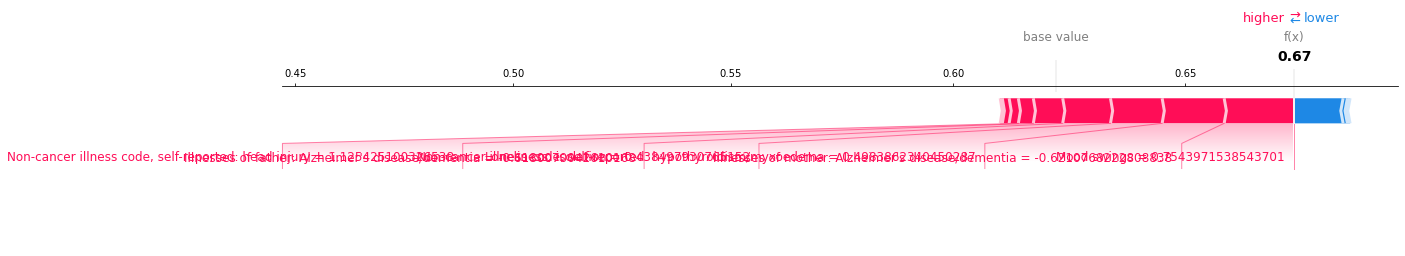

In [50]:
# print( shap_values_list )

# print the JS visualization code to the notebook
shap.initjs()

# print(shap_values[0, :])
# print(usable_features[0, :])
# shap.summary_plot(shap_values[:, :], usable_features[:, :])

# shap.force_plot(.5, shap_values[0,:], usable_features[0, :], link = "logit", matplotlib = True)  

# using pandas dataframe
shap.force_plot(.5, shap_values[0,:], shuffled_X.iloc[0, :], link = "logit", matplotlib = True  )  

In [40]:
# shap.force_plot(.5, shap_values[:,:], usable_features[:, :], link="logit")

# using pandas dataframe
print(shap_values.shape)
print(shuffled_X.shape)
shap.force_plot(.5, shap_values[:,:], shuffled_X.iloc[:, :], link="logit")

(640, 13)
(640, 13)


# Summary Plot
This plot is made of all the dots in the train data. It delivers the following information:

Feature importance: Variables are ranked in descending order.

Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

Correlation: A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “volatile acidity” is negatively correlated with the target variable.

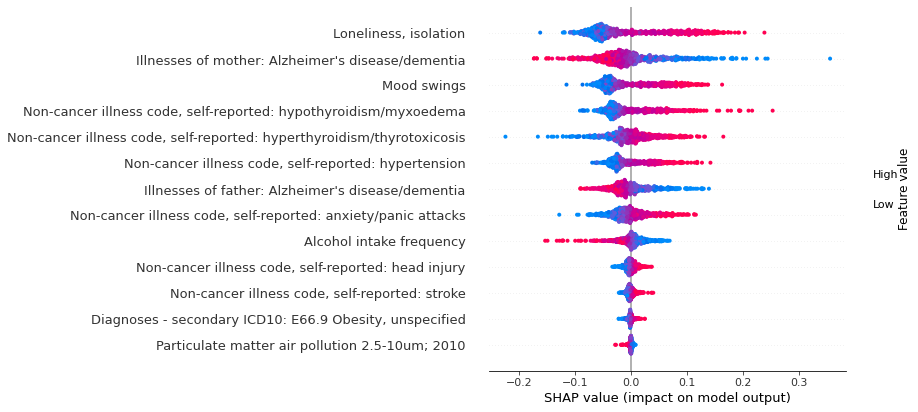

In [41]:
path = "./shap/" + str(num_features)
if not os.path.exists(path):
    os.makedirs(path)
    
# for trait in traits:
#     print(trait)
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# usable_features_std = (usable_features - usable_features.mean(0))/usable_features.std(0)
# shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='dot', max_display=len(traits), show = False)
# plt.savefig('shap/' + str(num_features) + '/summary_plot_hidden_'+ str(hidden) + '_dim_' + str(hidden_dimension) + '.pdf',  bbox_inches='tight')
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='dot', max_display=len(traits))

shap.summary_plot(shap_values, features = shuffled_X, feature_names=traits, plot_type='dot', max_display=len(traits), show = False)


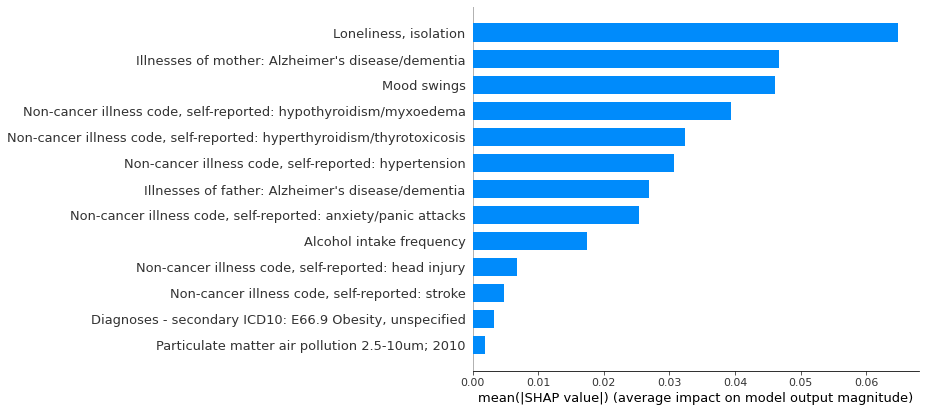

In [42]:
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='bar', max_display=len(traits), show=False)
# plt.savefig('shap/summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')
# naeem modified
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(num_features)), plot_type='bar', max_display=len(traits), show=False)
# shap.summary_plot(shap_values, features=usable_features, feature_names = traits, plot_type='bar', max_display=len(traits), show=False)
# plt.savefig('shap/' + str(num_features) + 'summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

shap.summary_plot(shap_values, features = shuffled_X, feature_names = traits, plot_type='bar', max_display=len(traits), show=False)
plt.savefig('shap/' + str(num_features) + 'summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

In [43]:
sorted(list(zip(list(range(23)), abs(shap_values).mean(0))), key=lambda x:x[1], reverse=True)

[(0, 0.0648188412931615),
 (2, 0.0466540663493676),
 (3, 0.046021974127859556),
 (9, 0.03939988472104773),
 (10, 0.03232204388359056),
 (11, 0.030681477181581197),
 (1, 0.026889757825054643),
 (4, 0.025399396398303086),
 (7, 0.017461461841136228),
 (6, 0.0067282619483553015),
 (5, 0.004823042520472739),
 (8, 0.0032980833923962234),
 (12, 0.0018588150732274495)]

In [44]:
help(shap.force_plot)


Help on function force in module shap.plots._force:

force(base_value, shap_values=None, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0, contribution_threshold=0.05)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float
        This is the reference value that the feature contributions start from. For SHAP values it should
        be the value of explainer.expected_value.
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
        force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    
    features : numpy.array
        Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
        features, an

# SVM 

In [45]:

# # print(Final_Samples)
# from sklearn.model_selection import train_test_split
# from sklearn import svm
# from sklearn.neural_network import MLPClassifier, MLPRegressor, BernoulliRBM

# feature_indices_to_consider = list(range(0, 23)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]

# usable_indices = [usable_samples_ADNI[Final_Samples[i][0]] for i in range(len(Final_Samples))]
# usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
# usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])

# Final_Samples = positive_samples[:500] + negative_samples[:500]
# random.seed(2);random.shuffle(Final_Samples)
# # Final_Samples = np.array(Final_Samples)
# print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
# print(sum(usable_labels), len(usable_labels))

# X_train, X_test, y_train, y_test = train_test_split(
#     usable_features, usable_labels, test_size=0.1)

# X_train.shape, y_train.shape

# X_test.shape, y_test.shape

# print(y_test.sum(), y_test.shape)
# clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
# # clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam').fit(X_train, y_train)
# clf.score(X_test, y_test)

# MLP

In [46]:
# random.shuffle(Final_Samples)
# usable_indices = [usable_samples_ADNI[Final_Samples[i][0]] for i in range(len(Final_Samples))]
# usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
# usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])


# from sklearn.model_selection import KFold
# X = usable_features[:, :23]
# y = usable_labels
# kf = KFold(n_splits=10)
# kf.get_n_splits(X)

# print(kf)
# # print(y_test)
# accuracies = []
# for train_index, test_index in kf.split(X):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
# #     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
# #     print(y_test.sum(), y_test.shape)
#     print(clf.score(X_test, y_test))
#     accuracies += [clf.score(X_test, y_test)]
# print(np.mean(accuracies), np.std(accuracies))


# Random Forest

In [47]:
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# accuracies = []
# X = usable_features[:, :23]
# y = usable_labels
# kf = KFold(n_splits=10)
# kf.get_n_splits(X)

# for train_index, test_index in kf.split(X):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     reg = RandomForestClassifier(random_state=0)
#     reg.fit(X_train, y_train)
#     print("Accuracy of model : ",reg.score(X_test, y_test)*100,"%")
# #     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
# #     print(y_test.sum(), y_test.shape)
#     accuracies += [reg.score(X_test, y_test)]
# print(np.mean(accuracies), np.std(accuracies))
# save_in_file("Random Forest", np.mean(accuracies))

# XGBoost

In [48]:
# from xgboost import XGBRegressor, XGBClassifier
# model_name = "XGB"

# accuracies = []
# for train_index, test_index in kf.split(X):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     reg = XGBClassifier()
#     reg.fit(X_train, y_train)
#     print("Accuracy of model : ",reg.score(X_test, y_test)*100,"%")
# #     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
# #     print(y_test.sum(), y_test.shape)
#     accuracies += [reg.score(X_test, y_test)]
# print(np.mean(accuracies), np.std(accuracies))
# save_in_file("XGBoost", np.mean(accuracies))


# Save accuracy in CSV

In [49]:
import csv

# open the file in the write mode
f = open('model_global_best_accuracy.csv', 'a')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
# writer.writerow(['num_features','num_nn_layers','global_best_accuracy'])
writer.writerow([str(num_features),str(hidden),str(global_best_acc_val)])

# close the file
f.close()